In [1]:
# CONFIG CELL
from notebook_utils import set_root_directory

set_root_directory()

In [2]:
import geopandas as gpd
import pandas as pd

from app import constants
from app.missing_values_percentage_filter import MissingValuesPercentageFilter
from app.voronoi_transfomer import VoronoiTransformer

In [3]:
SENSOR_METADATA = "input_files/sensor_metadata.parquet"
MEASUREMENTS_1H = "input_files/measurements_1h.parquet"
POLAND_POLYGON = "polska.zip"

In [4]:
poland = gpd.read_file(POLAND_POLYGON)
sensor_metadata = pd.read_parquet(SENSOR_METADATA)
measurements = pd.read_parquet(MEASUREMENTS_1H)
variable = constants.O3

In [5]:
mvpf = MissingValuesPercentageFilter(threshold=constants.MISSING_VALUES_THRESHOLD)
filtered_measurements = mvpf.fit_transform(X=measurements, variable=variable)

c:\Users\Mambo\Desktop\moje_AGH\staszel\daes-project-2425-ispies\app\missing_values_percentage_filter.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_X[constants.YEAR] = simple_X[constants.TIMESTAMP_COLUMN].dt.year


In [6]:
filtered_measurements.head(2)

,year,unique_id,O3
47,2000,102,0.001366
231,2000,536,0.029830


In [7]:
unique_sensor_ids = filtered_measurements.query(
    f"`{constants.YEAR}` == 2020"
)[constants.UNIQUE_ID].unique()

sensor_metadata = sensor_metadata.query(
    f"`{constants.SENSOR_ID}` in {unique_sensor_ids.tolist()}"
)

gdf_sensor_metadata = gpd.GeoDataFrame(
    sensor_metadata,
    geometry=gpd.points_from_xy(
        sensor_metadata[constants.LONGITUDE],
        sensor_metadata[constants.LATITUDE],
    ),
    crs=constants.GLOBAL_EPSG,
)
gdf_sensor_metadata = gdf_sensor_metadata.to_crs(constants.POLAND_EPSG)
gdf_sensor_metadata = gdf_sensor_metadata.reset_index(drop=True)

In [8]:
gdf_sensor_metadata.head(5)

,station_code,station_type,area_type,station_kind,latitude,longitude,province,city,sensor_id,old_station_code,geometry
0,DsJelGorOgin,tło,miejski,kontenerowa stacjonarna,50.913433,15.765608,DOLNOŚLĄSKIE,Jelenia Góra,30,[DsJeleniaGoraA],POINT (272714.868 343487.482)
1,DsKlodzSzkol,tło,miejski,kontenerowa stacjonarna,50.433493,16.653660,DOLNOŚLĄSKIE,Kłodzko,46,[DsKlodzkoA],POINT (333420.257 287783.557)
2,DsLegAlRzecz,tło,miejski,kontenerowa stacjonarna,51.204503,16.180513,DOLNOŚLĄSKIE,Legnica,56,[DsLegRzeczA],POINT (303104.84 374641.482)
3,DsLubanMieszMOB,tło,miejski,mobilna,51.119011,15.275539,DOLNOŚLĄSKIE,Lubań,68,[],POINT (239442.278 367956.51)
4,DsOlawZolnAK,tło,miejski,kontenerowa stacjonarna,50.942073,17.291333,DOLNOŚLĄSKIE,Oława,86,[DsOlawaSemi],POINT (379993.967 343079.199)


In [9]:
vt = VoronoiTransformer(
    mask_polygon=poland,
    buffer_size=constants.BUFFER_SIZE,
    buffer_points_amount=constants.BUFFER_POINTS_AMOUNT,
)

gdf_sensor_metadata[constants.VORONOI_GEOEMTRY] = vt.fit_transform(X=gdf_sensor_metadata)

C:\Users\Mambo\AppData\Local\Temp\ipykernel_31376\250637420.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


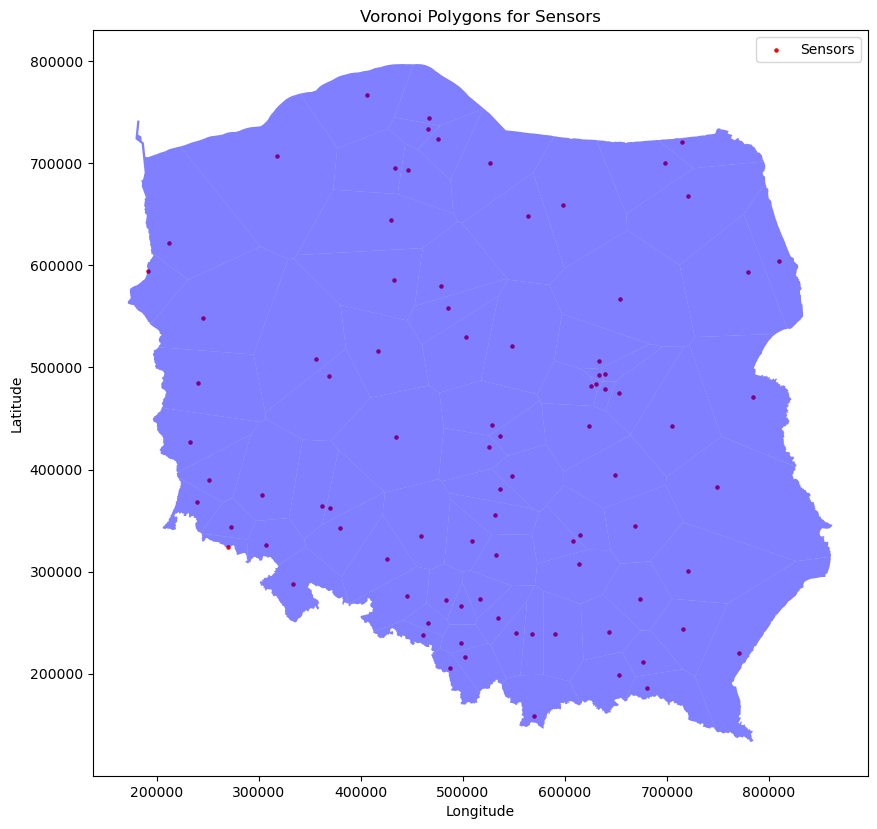

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))

gdf_sensor_metadata.plot(ax=ax, color="red", markersize=5, label="Sensors")
gdf_sensor_metadata.set_geometry(constants.VORONOI_GEOEMTRY).plot(ax=ax, color="blue", alpha=0.5, label="Voronoi Polygons")
# poland.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
ax.set_title("Voronoi Polygons for Sensors")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()